In [50]:
import torch
torch.cuda.is_available()


True

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import MNIST


In [52]:
BATCH_SIZE = 128

transform = transforms.Compose([
    transforms.ToTensor(),  # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # normalize inputs
])

mnist_train = MNIST('data', train=True, transform=transform, download=True)
mnist_test = MNIST('data', train=False, transform=transform, download=True)

dl_train = DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE,
                      num_workers=0, drop_last=True, shuffle=True)
dl_test = DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE,
                     num_workers=0, drop_last=False, shuffle=False)


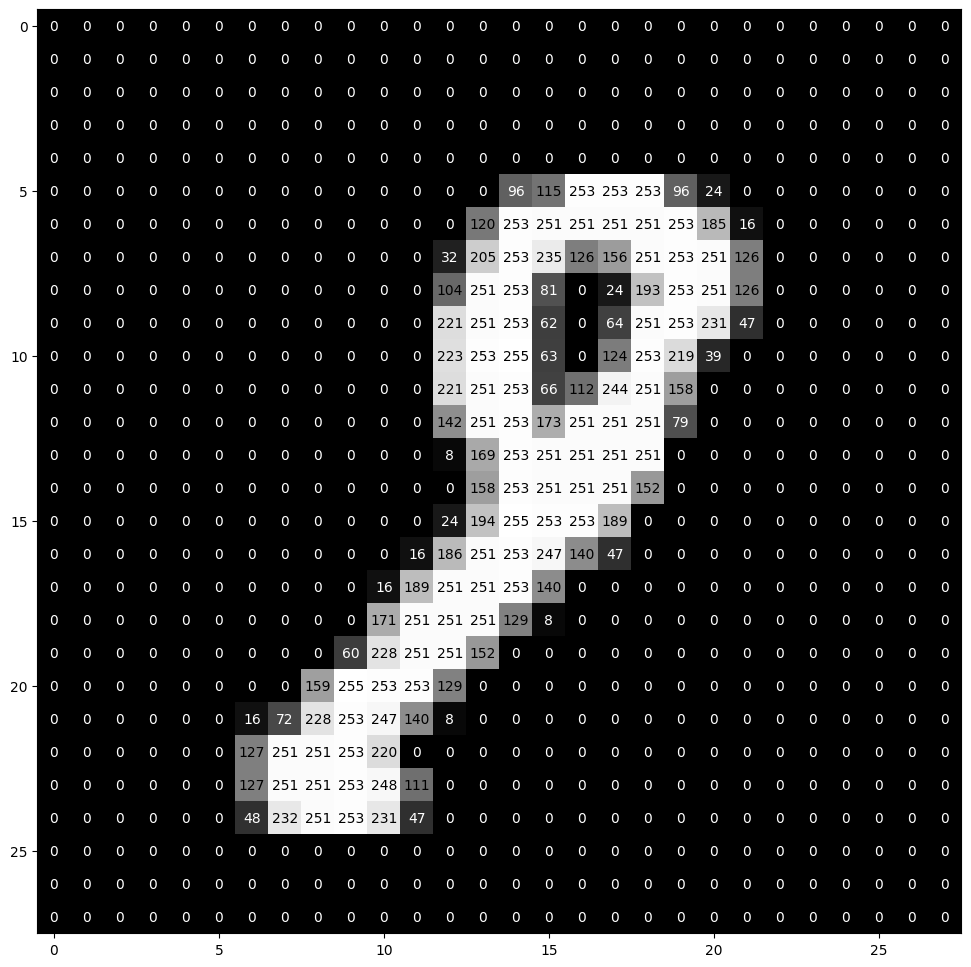

In [53]:
idx = np.random.choice(np.arange(0, len(mnist_train)))
img = mnist_train.data[idx]
img = np.reshape(img, (28, 28))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max() / 2.5
for x in range(width):
    for y in range(height):
        val = int(img[x][y]) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y] < thresh else 'black')


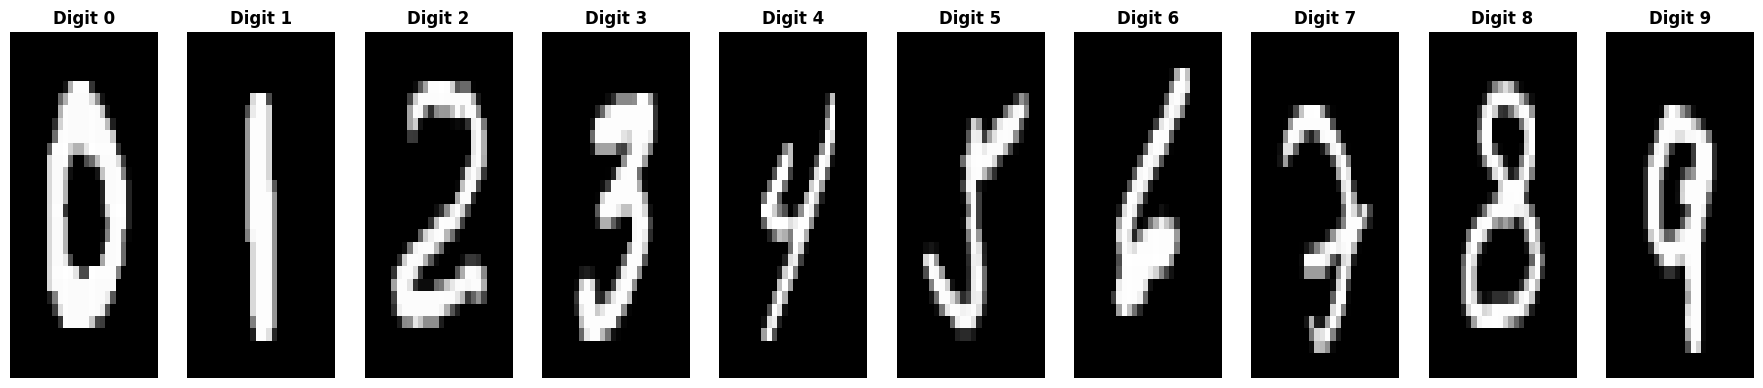

In [54]:
num_row, num_col = 1, 10
f, subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

for i in range(num_col):
    X, y = next(iter(dl_train))
    X_img = X[y == i]
    idx = np.random.choice(np.arange(0, X_img.shape[0]))

    X_img = X_img[idx]
    X_img = X_img.detach().cpu().numpy()
    X_img = X_img.squeeze()

    subplots[i].imshow(X_img, cmap='gray',
                       interpolation='nearest',
                       aspect='auto')
    subplots[i].set_title(f'Digit {i}', fontweight="bold")
    subplots[i].grid(visible=False)
    subplots[i].axis('off')

f.set_size_inches(22.5, 4.5)


In [55]:
import torch

num_epochs = 10
num_fin = 784
num_classes = 10
num_hidden = 128
learning_rate = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [56]:
import torch
import torch.nn as nn
from torch.optim import SGD

"""
  Write HERE your multi layer perceptron (MLP), with one hidden layer
  characterised by num_hidden neurons, activated by one OF the following
  activation functions: sigmoid, relu, leaky_relu (see the torch.nn package
  for details about act. functions)

  Here a list of functions that you may use:
    - nn.Sequential
    - nn.Linear
    - nn.Sigmoid
    - nn.ReLU
    - torch.argmax
    - optim.SGD, optim.Adam
    - nn.CrossEntropyLoss

  OPTIONALLY:
  i) Add more than just one hidden layer.
  ii) Put dropout and batch normalization layers to respectively improve
  the generalization capabilities and speedup training procedure.
"""


class MLP(nn.Module):

    def __init__(self, num_fin: int, num_hidden: int, num_classes: int):
        super(MLP, self).__init__()

        self.num_fin = num_fin
        self.num_hidden = num_hidden
        self.num_classes = num_classes

        """
          Define MLP building blocks here.
        """

        self.fc1 = nn.Linear(self.num_fin, self.num_hidden)
        self.fc2 = nn.Linear(self.num_hidden, self.num_classes)

        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor):
        B = x.shape[0]

        """
          x: input grayscale images (28x28) -> shape (B, 1, 28, 28)
          y: output predictions -> shape (B, self.num_classes)
        """

        # This will collapse our images into 784-dimensional vectors
        x = x.view(B, -1)

        """
          Define here the MLP forward pass.
        """

        x = self.fc1(x)
        x = self.act(x)
        y_pred = self.fc2(x)

        # y_pred = torch.rand((B, self.num_classes))

        return y_pred


def eval_acc(mlp: nn.Module, data_loader: torch.utils.data.DataLoader,
             device: torch.device):

    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            """
              Given y_pred (predictions) and y (groundtruth labels), acc
              should contain the number of right predictions.
            """

            acc = (torch.argmax(y_pred, dim=1) == y).sum().item()

            correct += acc
            total += y_pred.size(0)

    return correct / total


In [57]:
"""
  Define here the major components of the training algorithm.
"""
model = MLP(num_fin, num_hidden, num_classes).to(device)
loss_fun = nn.CrossEntropyLoss()
acc = None
opt = SGD(model.parameters(), lr=0.001, momentum=0.9)

try:

    for i in range(num_epochs):

        # Compute and print the accuracy, both on the training and the test set.
        print(f"Epoch {i} train acc.: {eval_acc(model, dl_train, device):.3f} "
              f"test acc.: {eval_acc(model, dl_test, device):.3f}")

        """
          Write HERE your code
          For each batch in the training set:
              -> Clear the gradients of all optimized variables
              -> Load the batch into the device.
              -> Forward pass: compute the predicted outputs by passing
                  inputs to the model
              -> Given the predictions, compute the loss function.
              -> Backward pass: compute gradient of the loss with respect
                  to model parameters
              -> Make an optimization step.
        """

        for i, data in enumerate(dl_train):
          inputs, labels = data

          inputs = inputs.to(device)
          labels = labels.to(device)

          opt.zero_grad()

          output = model(inputs)

          loss = loss_fun(output, labels)

          loss.backward()

          opt.step()


except KeyboardInterrupt:
    pass


Epoch 0 train acc.: 0.181 test acc.: 0.190
Epoch 1 train acc.: 0.887 test acc.: 0.897
Epoch 2 train acc.: 0.905 test acc.: 0.911
Epoch 3 train acc.: 0.914 test acc.: 0.919
Epoch 4 train acc.: 0.923 test acc.: 0.924
Epoch 5 train acc.: 0.928 test acc.: 0.928
Epoch 6 train acc.: 0.933 test acc.: 0.933
Epoch 7 train acc.: 0.937 test acc.: 0.937
Epoch 8 train acc.: 0.941 test acc.: 0.940
Epoch 9 train acc.: 0.944 test acc.: 0.941


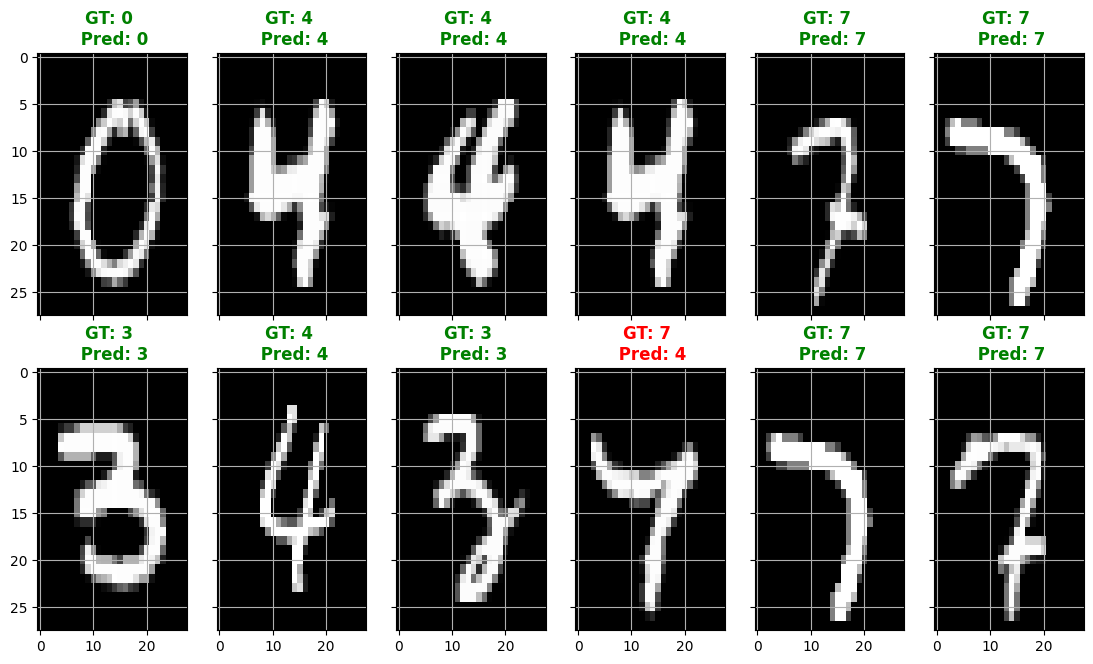

In [58]:
num_row, num_col = 2, 6
f, subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

X_batch, Y_batch = next(iter(dl_test))
X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

with torch.no_grad():
    Y_batch_pred = model(X_batch)

for i in range(num_row):
    for j in range(num_col):

        idx = np.random.choice(np.arange(0, X_batch.shape[0]))

        img = X_batch[idx].detach().cpu().numpy()

        target, pred = Y_batch[idx], Y_batch_pred[idx]
        target, pred = target.item(), torch.argmax(pred).item()
        target, pred = int(target), int(pred)
        is_correct = target == pred

        subplots[i, j].imshow(img.squeeze(), cmap="gray", interpolation='nearest',
                              aspect="auto")

        title = f"GT: {target} \n Pred: {pred}"
        color_title = 'green' if is_correct else 'red'
        subplots[i, j].set_title(title, color=color_title, fontweight="bold")
        subplots[i, j].grid()

f.set_size_inches(13.5, 7.5)
